<a href="https://colab.research.google.com/github/unicorn-yh/Image-Segmentation/blob/main/SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from glob import glob
import tensorflow as tf

In [13]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#data_path = '/content/gdrive/MyDrive/Dataset/'

In [14]:
data_path = 'Datasets/' 

train_path = data_path+"train/"
train_label_path = data_path+"trainannot/"

valid_path = data_path+"val/"
valid_label_path = data_path+"valannot/"

test_path = data_path+"test/"
test_label_path = data_path+"testannot/"

train_file = data_path + "train.p"
valid_file = data_path + "val.p"
test_file = data_path + "test.p"

In [15]:
train_list = sorted(glob(train_path + "*.png"))
train_label_list = sorted(glob(train_label_path + "*.png"))

valid_list = sorted(glob(valid_path + "*.png"))
valid_label_list = sorted(glob(valid_label_path + "*.png"))

test_list = sorted(glob(test_path + "*.png"))
test_label_list = sorted(glob(test_label_path + "*.png"))

train_count = len(train_list)
test_count = len(test_list)
valid_count = len(valid_list)

print(len(train_list),int(train_count))
print(len(test_list),int(test_count))
print(len(valid_list),int(valid_count))

367 367
233 233
101 101


In [16]:
#from google.colab.patches import cv2_imshow
def binarylab(labels):
    x = np.zeros([labels.shape[0],labels.shape[1],12])  
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            x[i,j,labels[i][j]]=1
    return x

def make_dataset(image_list, mask_list,num):
  images = []
  masks = []
  index = 0
  for img, mask in zip(image_list, mask_list):
    index += 1
    images.append(cv2.resize(cv2.imread(img), (224,224)))      # 224X224
    masks.append(binarylab(cv2.resize(cv2.imread(mask), (224,224))))
    if index == num: break
        
  images = np.array(images)
  masks = np.array(masks)
  return images, masks

In [17]:
X_train, y_train = make_dataset(train_list, train_label_list,int(train_count))
X_val, y_val = make_dataset(valid_list, valid_label_list,int(valid_count))
X_test, y_test = make_dataset(test_list, test_label_list,int(test_count))
print(X_train.shape,X_val.shape,X_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)

(367, 224, 224, 3) (101, 224, 224, 3) (233, 224, 224, 3)
(367, 224, 224, 12) (101, 224, 224, 12) (233, 224, 224, 12)


In [18]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f62aabd2790>,
 (-0.5, 223.5, 223.5, -0.5))

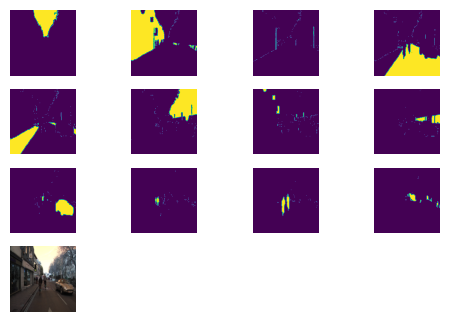

In [19]:
from matplotlib.gridspec import GridSpec
from random import randint, sample
ranidx = randint(0, len(y_train))
gs = GridSpec(4,4)
plt.figure(dpi=100)
for i in range(4*3):
    plt.subplot(gs[i]), plt.imshow(y_train[ranidx][:,:,i]), plt.axis('off')
    
plt.subplot(gs[12]), plt.imshow(X_train[ranidx]), plt.axis('off')

In [20]:
num_classes = 12
input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8

In [21]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

In [22]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization

#from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size, name="block1_pool")(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size, name="block2_pool")(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size, name="block3_pool")(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size, name="block4_pool")(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size, name="block5_pool")(conv_13)
   
    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Dense(12)(conv_26)  #softmax
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [24]:
model= segnet(input_shape=input_shape, n_labels=12)  #, single_model 

Build decoder done..


In [25]:
model.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 224, 224, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                            

In [26]:
VGG16_MODEL=tf.keras.applications.VGG16(include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [27]:
VGG16_MODEL.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [28]:
from tensorflow.keras.layers import Conv2D
layers = model.layers
merged_layers = []
count = 1
for _layer in layers:
  if isinstance(_layer, Convolution2D):
    merged_layers.append(_layer)
  if _layer.name == "block5_pool":
    break

vgg_layer =[]
vgg_layers = VGG16_MODEL.layers
for _layer in vgg_layers:
  if isinstance(_layer, Conv2D):
    vgg_layer.append(_layer)

for seg_model, vgg_model in zip(merged_layers, vgg_layer):
  wk0 = vgg_model.get_weights()
  seg_model.set_weights(wk0)



In [29]:
sgd = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer='sgd', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [30]:
X_train.shape

(468, 224, 224, 3)

In [31]:
history = model.fit(X_train, y_train,
                    batch_size=12,
                    epochs=200, 
                    shuffle=True,
                    validation_split=0.2)

Epoch 1/200
32/32 [==============================] - 48s 1s/step - loss: 2.7917 - acc: 0.1083 - val_loss: 2.3978 - val_acc: 0.2625
Epoch 2/200
32/32 [==============================] - 28s 884ms/step - loss: 2.4641 - acc: 0.2209 - val_loss: 2.3221 - val_acc: 0.2757
Epoch 3/200
32/32 [==============================] - 28s 889ms/step - loss: 2.2267 - acc: 0.3480 - val_loss: 2.2496 - val_acc: 0.2953
Epoch 4/200
32/32 [==============================] - 28s 885ms/step - loss: 2.0787 - acc: 0.3962 - val_loss: 2.1899 - val_acc: 0.2944
Epoch 5/200
32/32 [==============================] - 29s 911ms/step - loss: 1.9508 - acc: 0.4194 - val_loss: 2.1358 - val_acc: 0.2931
Epoch 6/200
32/32 [==============================] - 28s 890ms/step - loss: 1.8400 - acc: 0.4404 - val_loss: 2.0556 - val_acc: 0.2988
Epoch 7/200
32/32 [==============================] - 28s 888ms/step - loss: 1.7403 - acc: 0.4664 - val_loss: 1.9738 - val_acc: 0.3120
Epoch 8/200
32/32 [==============================] - 28s 891ms/st

In [32]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [33]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 15s 1s/step - loss: 0.9427 - acc: 0.7343


[0.9426907896995544, 0.734268307685852]

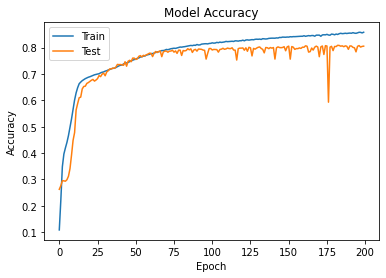

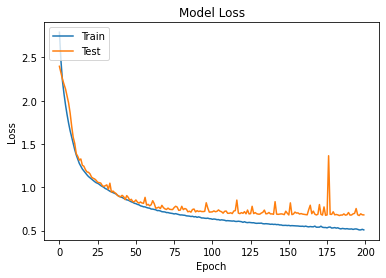

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

8/8 [==============================] - 9s 1s/step


(<Figure size 432x288 with 1 Axes>,
 (-0.5, 223.5, 223.5, -0.5))

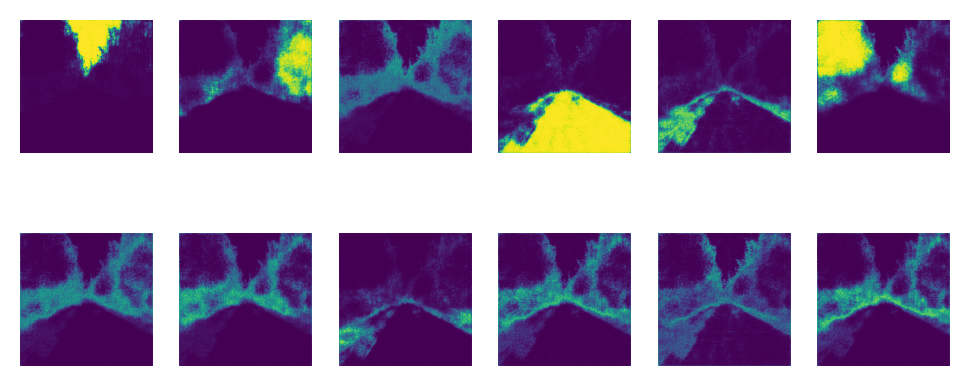

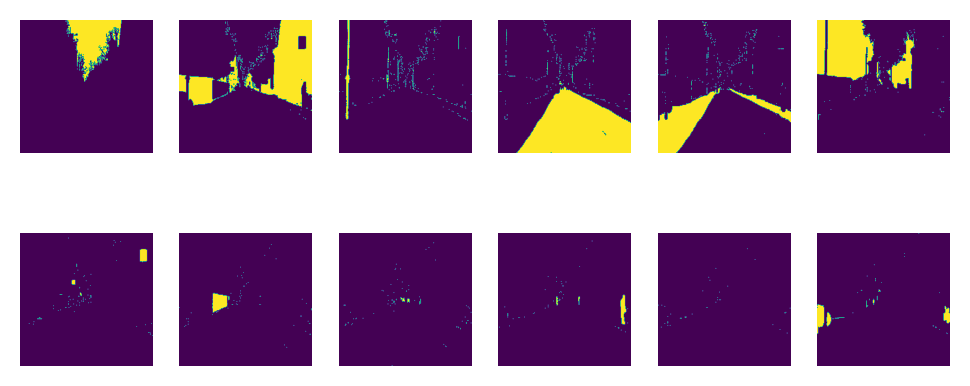

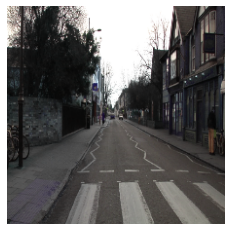

In [38]:
pred = model.predict(X_test, verbose=1)

ranidx = randint(0, len(y_test))
gs = GridSpec(3,6)
plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(pred[ranidx][:,:,i]), plt.axis('off')

plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(y_test[ranidx][:,:,i]), plt.axis('off')
    
plt.figure(),plt.imshow(X_test[ranidx]), plt.axis('off')

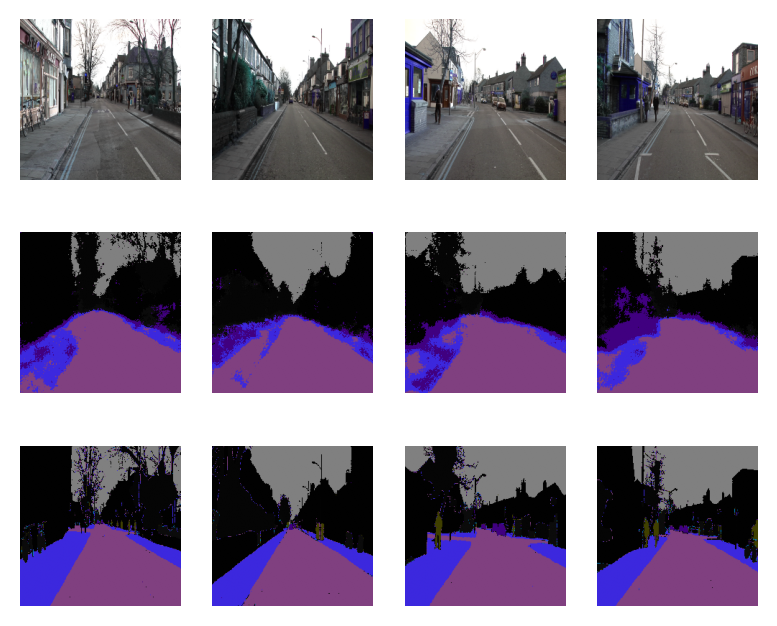

In [37]:
# refer from : https://github.com/preddy5/segnet/blob/master/Segnet.ipynb
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in [0, 3, 4, 8, 9, 10]:
        r[temp==l]=label_colours[l,0]                                                         
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

randsample = sample(range(0,len(pred)), 4)
gs = GridSpec(3,5)
plt.figure(dpi=200)

for i in range(4):
    output = visualize(np.argmax(pred[randsample[i]],axis=2).reshape((224,224)), plot=False)
    out_test = visualize(np.argmax(y_test[randsample[i]],axis=2).reshape((224,224)), plot=False)
        
    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5+i]), plt.imshow(output), plt.axis('off')
    plt.subplot(gs[10+i]), plt.imshow(out_test), plt.axis('off')

In [39]:
!python --version

Python 3.7.14
